In [2]:
import json
import csv
import pandas as pd
import datetime as dt
from matplotlib import pyplot
from pandas import read_csv
from matplotlib.dates import DateFormatter, DayLocator
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import mean_squared_error

### Loading modules 

First, we load the data. Then, we do some data cleaning in terms of the data types. 

In [3]:
df = pd.read_csv("/Users/nazanin.komeilizadeh/Downloads/adjusted_yellow_2022-01_2024-03_bypulocation.csv")
    

In [4]:
df.head()

,Unnamed: 0,PULocationID,pickup_datetime,counts,total_amount,tip_amount,fare_amount,trip_distance,passenger_count,trip_duration
0,0,4,2022-01-01 00:00:00-05:00,8,23.242388,1.886513,16.681875,3.363750,1.375000,14.481250
1,1,12,2022-01-01 00:00:00-05:00,1,36.592500,6.088500,25.830000,5.600000,4.000000,22.650000
2,2,13,2022-01-01 00:00:00-05:00,10,27.196531,3.027030,19.495500,4.386000,1.300000,14.801666
3,3,24,2022-01-01 00:00:00-05:00,10,18.574230,1.846230,12.915000,2.242000,1.200000,11.380000
4,4,41,2022-01-01 00:00:00-05:00,9,21.188799,1.549800,15.648334,3.082222,1.777778,13.890740


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1236501 entries, 0 to 1236500
Data columns (total 10 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   Unnamed: 0       1236501 non-null  int64  
 1   PULocationID     1236501 non-null  int64  
 2   pickup_datetime  1236501 non-null  object 
 3   counts           1236501 non-null  int64  
 4   total_amount     1236501 non-null  float64
 5   tip_amount       1236501 non-null  float64
 6   fare_amount      1236501 non-null  float64
 7   trip_distance    1236501 non-null  float64
 8   passenger_count  1236501 non-null  float64
 9   trip_duration    1236501 non-null  float64
dtypes: float64(6), int64(3), object(1)
memory usage: 94.3+ MB


In [6]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'],utc=True)                     

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1236501 entries, 0 to 1236500
Data columns (total 10 columns):
 #   Column           Non-Null Count    Dtype              
---  ------           --------------    -----              
 0   Unnamed: 0       1236501 non-null  int64              
 1   PULocationID     1236501 non-null  int64              
 2   pickup_datetime  1236501 non-null  datetime64[ns, UTC]
 3   counts           1236501 non-null  int64              
 4   total_amount     1236501 non-null  float64            
 5   tip_amount       1236501 non-null  float64            
 6   fare_amount      1236501 non-null  float64            
 7   trip_distance    1236501 non-null  float64            
 8   passenger_count  1236501 non-null  float64            
 9   trip_duration    1236501 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(6), int64(3)
memory usage: 94.3 MB


In [8]:
df.isna().sum()

Unnamed: 0         0
PULocationID       0
pickup_datetime    0
counts             0
total_amount       0
tip_amount         0
fare_amount        0
trip_distance      0
passenger_count    0
trip_duration      0
dtype: int64

In [9]:
df.drop(['Unnamed: 0','total_amount','tip_amount', 'fare_amount','trip_distance','passenger_count','trip_duration'], axis=1, inplace= True)

In [10]:
df.head()

,PULocationID,pickup_datetime,counts
0,4,2022-01-01 05:00:00+00:00,8
1,12,2022-01-01 05:00:00+00:00,1
2,13,2022-01-01 05:00:00+00:00,10
3,24,2022-01-01 05:00:00+00:00,10
4,41,2022-01-01 05:00:00+00:00,9


In [11]:
df['PULocationID'].unique()

array([  4,  12,  13,  24,  41,  42,  43,  45,  48,  50,  68,  74,  75,
        79,  87,  88,  90, 100, 107, 113, 114, 116, 120, 125, 127, 128,
       137, 140, 141, 142, 143, 144, 148, 151, 152, 158, 161, 162, 163,
       164, 166, 170, 186, 209, 211, 224, 229, 230, 231, 232, 233, 234,
       236, 237, 238, 239, 243, 244, 246, 249, 261, 262, 263])

In [12]:
df.shape

(1236501, 3)

### Loading the SARIMA package

In [13]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

### Using one Pick-up laction ID

In [14]:
location_id = 79
location_data = df[df['PULocationID'] == location_id].set_index('pickup_datetime')

# Aggregate the data by hour
hourly_data = location_data['counts'].resample('H').sum()

In [15]:
location_data.head()

,PULocationID,counts
pickup_datetime,,
2022-01-01 05:00:00+00:00,79,190
2022-01-01 06:00:00+00:00,79,276
2022-01-01 07:00:00+00:00,79,258
2022-01-01 08:00:00+00:00,79,205
2022-01-01 09:00:00+00:00,79,117


In [16]:
train_ratio = int(len(hourly_data)*0.8)

In [17]:
train_ratio

15762

In [18]:
train = hourly_data[:train_ratio]

In [19]:
test = hourly_data[train_ratio:]

In [20]:
train.head()

pickup_datetime
2022-01-01 05:00:00+00:00    190
2022-01-01 06:00:00+00:00    276
2022-01-01 07:00:00+00:00    258
2022-01-01 08:00:00+00:00    205
2022-01-01 09:00:00+00:00    117
Freq: H, Name: counts, dtype: int64

In [21]:
test.head()

pickup_datetime
2023-10-19 23:00:00+00:00    128
2023-10-20 00:00:00+00:00    176
2023-10-20 01:00:00+00:00    179
2023-10-20 02:00:00+00:00    210
2023-10-20 03:00:00+00:00    190
Freq: H, Name: counts, dtype: int64

### Grid Search for SARIMA

In [22]:
from sklearn.metrics import mean_squared_error
import itertools
import warnings
warnings.filterwarnings("ignore")


In [42]:
# Define the p, d, q ranges
p = d = q = range(0, 3)  # Example ranges for p, d, q
P = D = Q = range(0, 2)  # Example ranges for seasonal p, d, q
s = [24]  # Seasonal period (24 for hourly data with daily seasonality)

In [44]:
# Generate all combinations of parameters
pdq = list(itertools.product(p, d, q))
seasonal_pdq = list(itertools.product(P, D, Q, s))

# Initialize variables to store the best model and parameters
best_aic = float("inf")
best_params = None
best_model = None

# Grid search
for param in pdq:
    for seasonal_param in seasonal_pdq:
        try:
            # Fit the SARIMA model with current parameters
            model = SARIMAX(train,
                            order=param,
                            seasonal_order=seasonal_param,
                            enforce_stationarity=False,
                            enforce_invertibility=False)
            sarima_model = model.fit(disp=False)
           
            # Compare AIC
            if sarima_model.aic < best_aic:
                best_aic = sarima_model.aic
                best_params = (param, seasonal_param)
                best_model = sarima_model
            print(f"SARIMA{param}x{seasonal_param}24 - AIC:{sarima_model.aic}")
           
        except Exception as e:
            continue

print(f"\nBest SARIMA model: SARIMA{best_params[0]}x{best_params[1]}24 - AIC:{best_aic}")



SARIMA(0, 0, 0)x(0, 0, 0, 24)24 - AIC:197296.7553395324
SARIMA(0, 0, 0)x(0, 0, 1, 24)24 - AIC:183745.93493971467
SARIMA(0, 0, 0)x(0, 1, 0, 24)24 - AIC:181317.25528186432
SARIMA(0, 0, 0)x(0, 1, 1, 24)24 - AIC:180815.99643236055
SARIMA(0, 0, 0)x(1, 0, 0, 24)24 - AIC:179804.50652869232
SARIMA(0, 0, 0)x(1, 0, 1, 24)24 - AIC:178551.4302820923
SARIMA(0, 0, 0)x(1, 1, 0, 24)24 - AIC:181011.9062351007
SARIMA(0, 0, 0)x(1, 1, 1, 24)24 - AIC:175760.80181401887
SARIMA(0, 0, 1)x(0, 0, 0, 24)24 - AIC:179740.0592220938
SARIMA(0, 0, 1)x(0, 0, 1, 24)24 - AIC:170510.2969262013
SARIMA(0, 0, 1)x(0, 1, 0, 24)24 - AIC:168297.74660028913
SARIMA(0, 0, 1)x(0, 1, 1, 24)24 - AIC:164059.90528202488
SARIMA(0, 0, 1)x(1, 0, 0, 24)24 - AIC:166410.05066506332
SARIMA(0, 0, 1)x(1, 0, 1, 24)24 - AIC:166274.59905129072
SARIMA(0, 0, 1)x(1, 1, 0, 24)24 - AIC:168008.95971400233
SARIMA(0, 0, 1)x(1, 1, 1, 24)24 - AIC:162123.82127159095
SARIMA(0, 0, 2)x(0, 0, 0, 24)24 - AIC:168415.6835397023
SARIMA(0, 0, 2)x(0, 0, 1, 24)24 - AIC

SARIMA(2, 0, 0)x(0, 0, 1, 24)24 - AIC:150946.5788658376
SARIMA(2, 0, 0)x(0, 1, 0, 24)24 - AIC:155927.23818613478
SARIMA(2, 0, 0)x(0, 1, 1, 24)24 - AIC:148910.56613101542
SARIMA(2, 0, 0)x(1, 0, 0, 24)24 - AIC:150691.76027216366
SARIMA(2, 0, 0)x(1, 0, 1, 24)24 - AIC:150693.74374526335
SARIMA(2, 0, 0)x(1, 1, 0, 24)24 - AIC:154421.3938014444
SARIMA(2, 0, 0)x(1, 1, 1, 24)24 - AIC:148278.9824166867
SARIMA(2, 0, 1)x(0, 0, 0, 24)24 - AIC:152875.93908630783
SARIMA(2, 0, 1)x(0, 0, 1, 24)24 - AIC:150773.92947043382
SARIMA(2, 0, 1)x(0, 1, 0, 24)24 - AIC:155582.66246899866
SARIMA(2, 0, 1)x(0, 1, 1, 24)24 - AIC:148674.96515536192
SARIMA(2, 0, 1)x(1, 0, 0, 24)24 - AIC:150517.64016926827
SARIMA(2, 0, 1)x(1, 0, 1, 24)24 - AIC:150519.20131683222
SARIMA(2, 0, 1)x(1, 1, 0, 24)24 - AIC:154136.60855179958
SARIMA(2, 0, 1)x(1, 1, 1, 24)24 - AIC:148005.96592690644
SARIMA(2, 0, 2)x(0, 0, 0, 24)24 - AIC:152514.23596436952
SARIMA(2, 0, 2)x(0, 0, 1, 24)24 - AIC:150425.68942592925
SARIMA(2, 0, 2)x(0, 1, 0, 24)24 - 

##  Best SARIMA model: SARIMA(2, 0, 2)x(1, 1, 1, 24)24 - AIC:147681.89088567748


In [23]:
# Fit the SARIMA model
# Best SARIMA model: SARIMA(2, 0, 2)x(1, 1, 1, 24)24 - AIC:147681.89088567748
sarima_model = SARIMAX(train, order=(2, 0, 2), seasonal_order=(1, 1, 1, 24))
sarima_fit = sarima_model.fit(disp=False)

In [25]:
forecast = sarima_fit.get_forecast(steps=len(test))
forecast_mean = forecast.predicted_mean

In [26]:
forecast_mean


2023-10-19 23:00:00+00:00    116.864872
2023-10-20 00:00:00+00:00    135.327113
2023-10-20 01:00:00+00:00    163.862665
2023-10-20 02:00:00+00:00    169.467570
2023-10-20 03:00:00+00:00    154.039083
                                ...    
2024-03-31 23:00:00+00:00    104.363583
2024-04-01 00:00:00+00:00    114.395157
2024-04-01 01:00:00+00:00    140.642482
2024-04-01 02:00:00+00:00    158.401614
2024-04-01 03:00:00+00:00    152.144424
Freq: H, Name: predicted_mean, Length: 3941, dtype: float64

In [27]:
mse = mean_squared_error(test, forecast_mean)


In [28]:
mse

6110.2173668507685

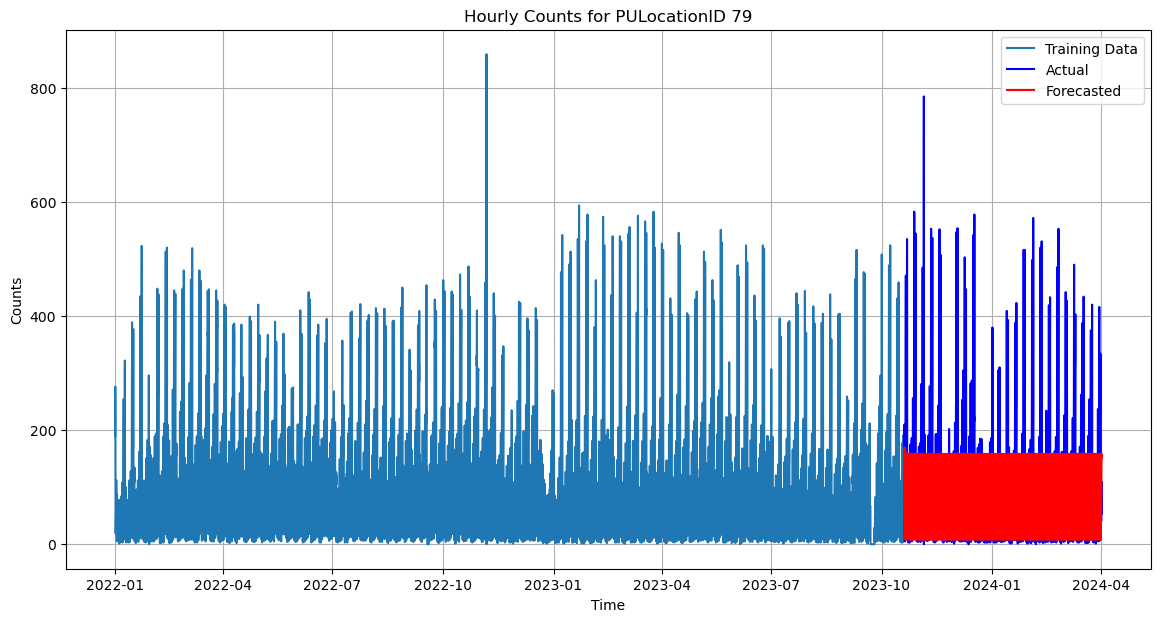

In [29]:
# Plot the results 
plt.figure(figsize=(14, 7))
plt.plot(train.index, train, label='Training Data')
plt.plot(test.index, test, label='Actual', color='blue')
plt.plot(forecast_mean.index, forecast_mean, label='Forecasted', color='red')
plt.title(f'Hourly Counts for PULocationID 79')
plt.xlabel('Time')
plt.ylabel('Counts')
plt.legend()
plt.grid(True)
plt.show()

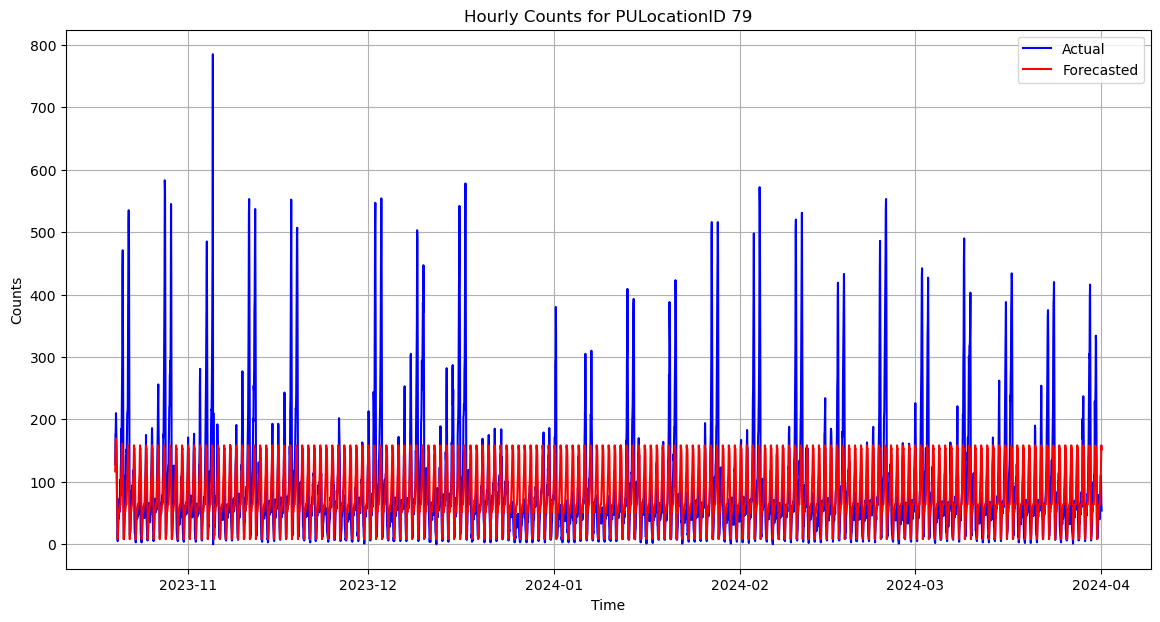

In [30]:
# Plot the results 
plt.figure(figsize=(14, 7))
#plt.plot(train.index, train, label='Training Data')
plt.plot(test.index, test, label='Actual', color='blue')
plt.plot(forecast_mean.index, forecast_mean, label='Forecasted', color='red')
plt.title(f'Hourly Counts for PULocationID 79')
plt.xlabel('Time')
plt.ylabel('Counts')
plt.legend()
plt.grid(True)
plt.show()

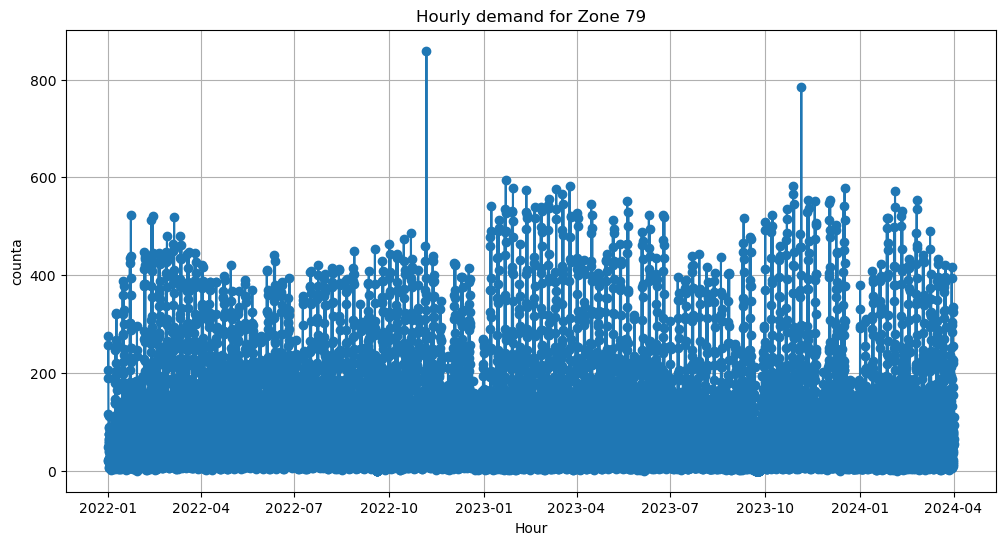

In [31]:
plt.figure(figsize=(12, 6))
plt.plot(location_data.index, location_data['counts'], marker='o')
plt.title('Hourly demand for Zone 79')
plt.xlabel('Hour')
plt.ylabel('counta')
plt.grid(True)
plt.show()

# end for now 

In [ ]:
# Forecast on the test data
forecast = best_model.get_forecast(steps=len(test_data))
forecast_mean = forecast.predicted_mean

# Calculate MSE
mse = mean_squared_error(test_data, forecast_mean)
print(f'MSE: {mse}')

# Plot the actual vs forecasted counts
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.plot(train_data.index, train_data, label='Training Data')
plt.plot(test_data.index, test_data, label='Actual Counts', color='blue')
plt.plot(forecast_mean.index, forecast_mean, label='Forecasted Counts', color='red', linestyle='--')
plt.title('Actual vs Forecasted Counts')
plt.xlabel('Datetime')
plt.ylabel('Counts')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
 # Store the result
    mse_results[location] = mse

# Convert the results to a DataFrame
mse_df = pd.DataFrame(list(mse_results.items()), columns=['PULocationID', 'MSE'])

import ace_tools as tools; tools.display_dataframe_to_user(name="MSE Results for PULocationID", dataframe=mse_df)

In [ ]:
# Forecast the next 24 hours
forecast = sarima_fit.get_forecast(steps=24)
forecast_index = pd.date_range(start=hourly_data.index[-1] + pd.Timedelta(hours=1), periods=24, freq='H')
forecast_series = pd.Series(forecast.predicted_mean, index=forecast_index)


In [30]:
location_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19627 entries, 2022-01-01 05:00:00+00:00 to 2024-04-01 03:00:00+00:00
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   PULocationID  19627 non-null  int64
 1   counts        19627 non-null  int64
dtypes: int64(2)
memory usage: 460.0 KB


In [27]:
hourly_data

pickup_datetime
2022-01-01 05:00:00+00:00    190
2022-01-01 06:00:00+00:00    276
2022-01-01 07:00:00+00:00    258
2022-01-01 08:00:00+00:00    205
2022-01-01 09:00:00+00:00    117
                            ... 
2024-03-31 23:00:00+00:00     93
2024-04-01 00:00:00+00:00    110
2024-04-01 01:00:00+00:00     94
2024-04-01 02:00:00+00:00     65
2024-04-01 03:00:00+00:00     54
Freq: H, Name: counts, Length: 19703, dtype: int64

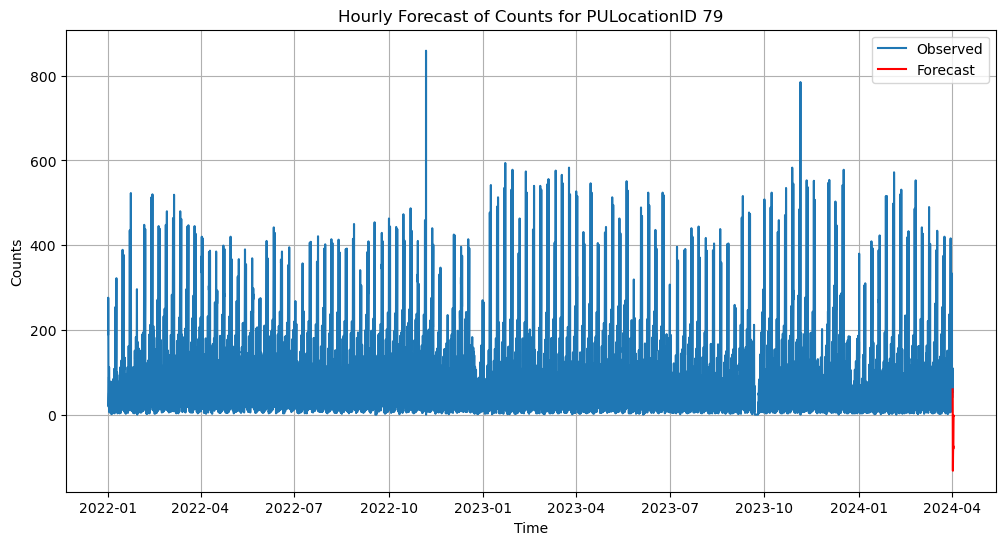

In [33]:
# Plot the results 
plt.figure(figsize=(12, 6))
plt.plot(hourly_data, label='Observed')
plt.plot(forecast_series, label='Forecast', color='red')
plt.title(f'Hourly Forecast of Counts for PULocationID {location_id}')
plt.xlabel('Time')
plt.ylabel('Counts')
plt.legend()
plt.grid(True)
plt.show()

In [36]:
# MSE
from sklearn.metrics import mean_squared_error

sarima_pred =sarima_fit.get_prediction(start=0, emd=-1)


In [37]:
predicted_values = sarima_pred.predicted_mean

In [39]:
mse = mean_squared_error(hourly_data,predicted_values )

In [40]:
mse

868.5876537135841

In [ ]:
# Get a list of unique PULocationIDs
unique_locations = data['PULocationID'].unique()

# Initialize a dictionary to store MSE for each location
mse_results = {}

# Iterate over each PULocationID
for location in unique_locations:
    # Filter the data for the current PULocationID
    location_data = data[data['PULocationID'] == location]
   
    # Set the pickup_datetime as the index and aggregate by hour
    location_data.set_index('pickup_datetime', inplace=True)
    location_data_hourly = location_data['counts'].resample('H').sum()
   
    # Split data into train and test sets
    train_data = location_data_hourly[:-24]
    test_data = location_data_hourly[-24:]
   
    # Fit a SARIMA model
    model = SARIMAX(train_data, order=(1, 1, 1), seasonal_order=(1, 1, 1, 24))
    sarima_model = model.fit(disp=False)
   
    # Forecast for the next 24 hours
    forecast = sarima_model.get_forecast(steps=24)
    forecast_mean = forecast.predicted_mean
   
    # Calculate the MSE
    mse = mean_squared_error(test_data, forecast_mean)
   
    # Store the result
    mse_results[location] = mse

# Convert the results to a DataFrame
mse_df = pd.DataFrame(list(mse_results.items()), columns=['PULocationID', 'MSE'])

import ace_tools as tools; tools.display_dataframe_to_user(name="MSE Results for PULocationID", dataframe=mse_df)